## Sine wave anomaly_likelihood

In [1]:
import numpy as np
import math

from htm.bindings.sdr import SDR
from htm.bindings.encoders import ScalarEncoder, ScalarEncoderParameters
from htm.algorithms import SpatialPooler as SP
from htm.algorithms import TemporalMemory as TM
from htm.bindings.algorithms import Predictor
from htm.algorithms.anomaly_likelihood import AnomalyLikelihood 

import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

In [2]:
scalarEncoderParams = ScalarEncoderParameters()
scalarEncoderParams.minimum = -1
scalarEncoderParams.maximum = 1
scalarEncoderParams.activeBits = 4
scalarEncoderParams.size = 128
scalarEncoderParams.clipInput  = True

enc = ScalarEncoder(scalarEncoderParams)

In [3]:
inputSDR  = SDR( dimensions = (128, ) )
activeSDR = SDR( dimensions = (576,) )
sp = SP(inputDimensions  = inputSDR.dimensions,
        columnDimensions = activeSDR.dimensions,
        localAreaDensity = 0.02,
        globalInhibition = True,
        seed             = 1,
        synPermActiveInc   = 0.01,
        synPermInactiveDec = 0.008)

In [4]:
tm = TM(
    columnDimensions = (576,),
    cellsPerColumn=8,
    initialPermanence=0.5,
    connectedPermanence=0.5,
    minThreshold=8,
    maxNewSynapseCount=20,
    permanenceIncrement=0.1,
    permanenceDecrement=0.0,
    activationThreshold=8,
)

In [5]:
predictor = Predictor( steps=[1,2,3,4,5])

In [6]:
rows = 500

# anomary
probationaryPeriod = int(math.floor(float(0.1)*rows))
learningPeriod     = int(math.floor(probationaryPeriod / 2.0))
anomaly_history = AnomalyLikelihood(learningPeriod= learningPeriod,
                                  estimationSamples= probationaryPeriod - learningPeriod,
                                  reestimationPeriod= 100)
anomaly     = []
anomalyProb = []

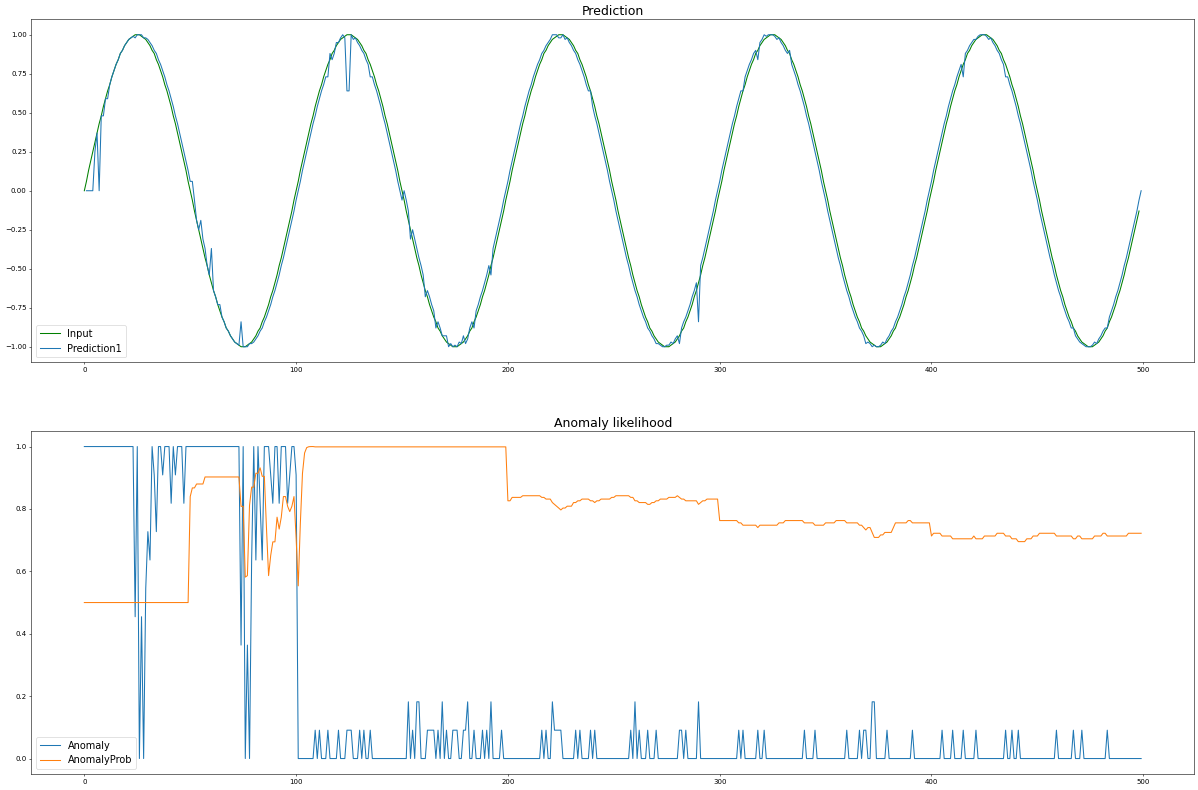

In [8]:
sine_wave={}
predictions = {1: [], 2: [], 3: [], 4: [], 5: []}
for i in range(rows):
    angle = (i * np.pi) / 50.0
    sine_value = np.sin(angle)
    sine_wave[i]=round(sine_value,2)
    
    inputSDR = enc.encode(sine_wave[i])
    sp.compute(inputSDR, True, activeSDR)

    tm.compute( activeSDR, learn=True)
    
    predictor.learn(i, tm.getActiveCells(), int(list(sine_wave)[i]))

    pdf = predictor.infer( tm.getActiveCells() )
    for n in (1,2,3,4,5):
        if pdf[n]:
            predictions[n].append( sine_wave[np.argmax( pdf[n] )] )
        else:
            predictions[n].append(float("nan"))
    
    anomalyLikelihood = anomaly_history.anomalyProbability( list(sine_wave)[i], tm.anomaly )
    
    anomaly.append( tm.anomaly )
    anomalyProb.append( anomalyLikelihood )
    
    clear_output(wait = True)
    plt.cla
    plot = plt.figure(figsize=(30,20),dpi=50)
    plt.subplot(2, 1, 1)
    plt.plot(list(sine_wave.values())[0:i], color='green', linestyle = "solid",label="Input")
    plt.plot(predictions[1],label="Prediction1")
    plt.title("Prediction", fontsize=18)
    plt.legend(loc='lower left', fontsize=14)
    plt.subplot(2, 1, 2)
    plt.plot(anomaly,label="Anomaly")
    plt.plot(anomalyProb,label="AnomalyProb")
    plt.title("Anomaly likelihood", fontsize=18)
    plt.legend(loc='lower left', fontsize=14)
    plt.show()